# Elevated-Plus Maze Analysis

In [1]:
from analysis import analysis_utils as au
from IPython.core.interactiveshell import InteractiveShell
from multiprocessing import Process
from multiprocessing import Queue
import numpy as np
import os
import pandas as pd
import random
from scipy import stats
import seaborn as sns
import SigProc
import sys

In [2]:
%matplotlib inline
InteractiveShell.ast_node_interactivity = "all"

In [3]:
sns.set_style("darkgrid")

In [4]:
mouse_directory = os.path.expanduser("~") + "/Hen_Lab/Mice/EPM"

if not os.path.exists(mouse_directory):
    print("The mouse directory does not exist", file=sys.stderr)

file_num = 0
raw_files = list()
for dir_name, subdir_list, file_list in os.walk(mouse_directory):
    for file_name in file_list:
        if file_name.endswith(".csv"):
            print("{}. full path of: {} is: {}".format(file_num, file_name, dir_name+"/"+file_name))
            file_num += 1
            raw_files.append(dir_name+"/"+file_name)

0. full path of: behavior_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/behavior_drd87.csv
1. full path of: Raw_EPM_drd87.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd87/Raw_EPM_drd87.csv
2. full path of: Raw_EPM_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/Raw_EPM_drd73.csv
3. full path of: behavior_drd73.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd73/behavior_drd73.csv
4. full path of: Raw_EPM_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/Raw_EPM_drd77.csv
5. full path of: behavior_drd77.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd77/behavior_drd77.csv
6. full path of: behavior_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/behavior_drd46.csv
7. full path of: Raw_EPM_drd46.csv is: /Users/saveliyyusufov/Hen_Lab/Mice/EPM/drd46/Raw_EPM_drd46.csv


In [5]:
# au.run_epm_analysis(raw_files)

In [6]:
data = pd.read_csv(raw_files[1], header=None)
_, AUC_dataframe, cell_transients_dataframe = SigProc.detect_ca_transients_mossy(data, 2, 0.5, 0.2, 10)

In [7]:
au.neuron_line_plot(AUC_dataframe, "neuron38", "neuron45")

## TODO: Discuss and streamline the below functionality, turn it into a function, make sure the function is sound, and move it to `analysis_utils.py`

In [8]:
behavior_column_names = ['Trial_time', 'Recording_time', 'X_center', 'Y_center', 'Area', 'Areachange', 
                         'Elongation', 'Distance_moved', 'Velocity', 'Arena_centerpoint',
                         'Open1_centerpoint', 'Open2_centerpoint',
                         'Closed1_centerpoint', 'Closed2_centerpoint',
                         'OpenArms_centerpoint', 'ClosedArms_centerpoint', 'Result_1']

behavior_df = pd.read_csv(raw_files[0], header=None)
behavior_df.columns = behavior_column_names
behavior_df = au.downsample_dataframe(behavior_df, 3)

# Define what constitutes as a running frame
VELOCITY_CUTOFF = 4;

# Adds "Running_frames" column to the end of the behavior Dataframe 
behavior_df["Running_frames"] = np.where(behavior_df["Velocity"] > VELOCITY_CUTOFF, 1, 0)

In [9]:
neuron_concated_behavior = AUC_dataframe.join(behavior_df, how="left")

In [10]:
def compute_diff_rate(dataframe, neuron_activity_df, *behaviors, frame_rate=10):
    """Computes difference between the rates of two behaviors
    
    Args: 
        dataframe: the the concatenated pandas DataFrame of an animal's neuron 
        activity and corresponding behavior
        neuron_col_names: the names of the neuron columns in the DataFrame
        *behaviors: a single or ordered pair of behaviors to compute the difference
        rate for, e.g. "Running", e.g. "ClosedArms", "OpenArms"
        frame_rate: the framerate associated with the given data; default is 10
    
    Returns:
        a numpy array of all the means of the behavior vectors subtracted from the 
        corresponding means of the non-behavior vectors, all scaled by frame rate
    """
    if len(behaviors) == 1:  
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[0]] == 0, neuron_activity_df.columns]
        return frame_rate * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))
    elif len(behaviors) == 2:
        beh_vec = dataframe.loc[dataframe[behaviors[0]] != 0, neuron_activity_df.columns]
        no_beh_vec = dataframe.loc[dataframe[behaviors[1]] != 0, neuron_activity_df.columns]
        return frame_rate * (beh_vec.values.mean(axis=0) - no_beh_vec.values.mean(axis=0))

In [11]:
# compute_diff_rate(neuron_concated_behavior, AUC_dataframe.columns, "OpenArms_centerpoint")

In [12]:
def set_real_diff_df(dataframe, neuron_act_df, behavior):
    """Compute the real difference mean values for all neurons
    
    Args:
        dataframe: the concatenated pandas DataFrame of the neuron activity
        DataFrame and corresponding behavior DataFrame, for a given animal
        neuron_activity_df: the pandas DataFrame of neuron activity,
        for a given animal
        behavior: the behavior for which to compute the difference rate
        
    
    Returns:
        real_df: a pandas DataFrame of with one row of all the real difference
        values computed for all the neurons for a given animal
    """
    real_df = pd.DataFrame(columns=neuron_act_df.columns, index=["d"])
    real_df.loc['d'] = compute_diff_rate(dataframe, neuron_act_df, behavior)
    return real_df

In [13]:
real_diff_df = set_real_diff_df(neuron_concated_behavior, AUC_dataframe, "OpenArms_centerpoint")
real_diff_df

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
d,-3.22914,6.88128,4.24304,12.0378,5.60818,-0.628605,1.31964,-2.75311,-1.93266,0.808019,...,9.17461,-1.65544,6.08556,0.810677,4.41841,8.53101,5.52316,1.23241,-1.93298,12.4688


In [14]:
def shuffle_worker(q, num_of_experiments, neuron_activity_df, neuron_and_behavior_df, behavior):
    """Helper function for shuffle()

    Given a certain number of experiments to simulate, this function will
    add a dataframe to a provided queue full of the amount of experiments 
    desired as obervations rows. 
    Note: This function is meant to be only be used as a helper function 
    for the shuffle() function

    Args:
        q: the blocking queue to which the resulting dataframe will be added to
        num_of_experiments: the number of experiments that will be simulated 
        and appended, as observations, to the dataframe to be returned
        neuron_activity_df: the neuron activity dataframe for a given mouse
        neuron_and_behavior_df: the concatenated neuron activity and behavior 
        dataframes for a given mouse 
        behavior: the specific behavior to simulate the experiments on
    """ 
    first_col = neuron_activity_df.columns[0]
    last_col = neuron_activity_df.columns[len(neuron_activity_df.columns)-1]
    shuffled_df = pd.DataFrame(columns=neuron_activity_df.columns)
    
    for index in range(num_of_experiments):
        neuron_and_behavior_df.loc[:, first_col:last_col] = neuron_and_behavior_df.loc[:, first_col:last_col].sample(frac=1).reset_index(drop=True)
        shuffled_df.loc[index] = compute_diff_rate(neuron_and_behavior_df, neuron_activity_df, behavior)

    q.put(shuffled_df)

In [15]:
def shuffle(total_experiments, neuron_and_behavior_df, neuron_activity_df, behavior):
    """Homebrewed resampling function for EPM Analysis
    
    Resampling function that gives the capability to "simulate"
    experiments using random shuffling of the observations for each 
    pandas dataframe. 
    
    Args: 
        total_experiments: the total amount of epxeriments to simulate via bootstrapping
        neuron_and_behavior_df: the concatenated neuron activity and behavior dataframes
        for a given animal
        neuron_activity_df: the neuron activity dataframe for a given animal
        behavior: the specific behavior to simulate the experiments on
    
    Returns: a (vertically) concatenated pandas DataFrame of all the shuffled DataFrames 
    that all the shuffle_worker processes produced
    """
    experiments_per_worker = total_experiments // os.cpu_count() 
    q = Queue()
    processes = []
    rets = []
    for _ in range(0, os.cpu_count()):
        p = Process(target=shuffle_worker, args=(q, experiments_per_worker, neuron_activity_df, neuron_and_behavior_df, behavior))
        processes.append(p)
        p.start()
    for p in processes:
        ret = q.get()  # will block
        rets.append(ret)
    for p in processes:
        p.join()

    return pd.concat(rets, ignore_index=True)

In [16]:
bootstrapped = shuffle(100000, neuron_concated_behavior, AUC_dataframe, "OpenArms_centerpoint")

In [17]:
bootstrapped

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
0,3.056729,-1.501363,1.770340,-0.753406,6.109825,-1.082367,0.565563,-2.110296,-0.771069,-0.670154,...,-1.806329,1.173763,-1.321239,2.870021,-0.282891,-0.649814,-1.512472,-1.844326,-1.684004,-2.459600
1,-1.707160,-1.501363,1.105279,-1.369423,-3.170872,-1.082367,-1.488887,7.072463,-0.532998,2.223410,...,0.703225,1.647754,0.142955,0.314002,0.526073,1.184039,-1.274164,-0.143031,-0.547533,-2.156478
2,-3.229137,-1.501363,-0.242460,-0.080617,5.753891,-1.082367,-1.475662,-3.130823,-1.923198,0.593380,...,5.788099,-1.655441,-0.288108,-2.591038,-1.415268,-0.720364,-0.584070,-0.666362,0.221815,0.247067
3,-2.529681,0.072767,-1.541086,0.081029,0.802351,-1.082367,-0.347758,-0.325383,2.669279,-1.222411,...,0.703225,-1.081956,-0.314345,0.280779,-1.462550,0.669239,-0.196294,-0.837937,-0.758553,-1.038917
4,9.008015,-1.501363,2.154720,-0.088222,7.516988,-1.082367,-1.718056,4.934713,-1.998294,-0.891953,...,-1.806329,3.787460,1.841331,0.659864,-1.437592,2.534231,-1.512472,1.409645,-0.547533,-2.459600
5,5.612718,-0.666861,-1.262249,0.412162,-2.580106,-1.082367,-1.334579,-2.483284,-1.392523,-2.176805,...,6.200576,-1.655441,-1.321239,-1.547773,-1.437592,-0.981057,4.309015,-0.123262,7.026531,1.735972
6,-3.229137,0.110724,3.298711,-1.206869,-2.224407,-1.082367,1.266213,-1.180716,4.250902,0.213015,...,0.703225,3.215446,1.855995,-1.090602,3.937034,-0.770694,-0.943691,-1.787119,-1.932984,5.030237
7,-3.229137,-1.501363,-2.039670,-0.761266,-0.807932,-0.870564,-1.484082,-1.409349,8.208015,1.291884,...,-1.806329,-1.049436,1.869031,0.177967,-1.326352,-1.081127,-1.158198,-0.475309,0.553415,-1.992615
8,11.386788,0.110724,1.238850,0.198002,-0.524969,-1.082367,0.331590,-2.561283,-2.960427,-2.176805,...,-1.033950,3.918473,-1.321239,0.760291,-1.750552,-1.484262,1.508317,-2.300531,1.569385,-1.855340
9,-2.529681,-1.093780,-1.771790,-1.713181,9.053467,-0.870564,2.484527,-2.118174,0.404045,-0.678286,...,3.217757,-1.393752,-0.565833,-1.200630,0.030069,-0.860738,1.192802,-1.162056,-0.323156,-0.228186


In [18]:
bootstrapped_copy = bootstrapped.copy()
col = 0
for col in range(0, len(bootstrapped_copy.columns)):
    bootstrapped_copy.iloc[:, col] += abs(bootstrapped_copy.min()[col])
    col += 1

In [19]:
bootstrapped_copy

,neuron1,neuron2,neuron3,neuron4,neuron5,neuron6,neuron7,neuron8,neuron9,neuron10,...,neuron60,neuron61,neuron62,neuron63,neuron64,neuron65,neuron66,neuron67,neuron68,neuron69
0,6.285866e+00,2.220446e-16,4.452709e+00,9.597748e-01,9.280698e+00,0.000000,2.283619e+00,1.020527e+00,2.602293e+00,1.506651e+00,...,0.000000e+00,2.829204e+00,2.220446e-16,5.461060e+00,1.467662e+00,1.095141e+00,6.661338e-16,4.562053e-01,2.489796e-01,0.000000e+00
1,1.521977e+00,2.220446e-16,3.787649e+00,3.437577e-01,4.440892e-16,0.000000,2.291685e-01,1.020329e+01,2.840364e+00,4.400215e+00,...,2.509555e+00,3.303195e+00,1.464194e+00,2.905040e+00,2.276625e+00,2.928994e+00,2.383082e-01,2.157500e+00,1.385451e+00,3.031220e-01
2,4.440892e-16,2.220446e-16,2.439910e+00,1.632564e+00,8.924763e+00,0.000000,2.423937e-01,8.881784e-16,1.450164e+00,2.770185e+00,...,7.594428e+00,2.220446e-16,1.033131e+00,4.440892e-16,3.352844e-01,1.024592e+00,9.284025e-01,1.634170e+00,2.154799e+00,2.706667e+00
3,6.994562e-01,1.574130e+00,1.141283e+00,1.794210e+00,3.973224e+00,0.000000,1.370298e+00,2.805440e+00,6.042641e+00,9.543938e-01,...,2.509555e+00,5.734854e-01,1.006894e+00,2.871818e+00,2.880027e-01,2.414195e+00,1.316178e+00,1.462594e+00,1.174431e+00,1.420683e+00
4,1.223715e+01,2.220446e-16,4.837090e+00,1.624960e+00,1.068786e+01,0.000000,2.220446e-16,8.065536e+00,1.375067e+00,1.284852e+00,...,0.000000e+00,5.442901e+00,3.162570e+00,3.250902e+00,3.129598e-01,4.279186e+00,6.661338e-16,3.710176e+00,1.385451e+00,4.440892e-16
5,8.841854e+00,8.345019e-01,1.420121e+00,2.125343e+00,5.907667e-01,0.000000,3.834772e-01,6.475392e-01,1.980839e+00,4.440892e-16,...,8.006906e+00,6.661338e-16,2.220446e-16,1.043265e+00,3.129598e-01,7.638986e-01,5.821488e+00,2.177270e+00,8.959515e+00,4.195571e+00
6,8.881784e-16,1.612087e+00,5.981081e+00,5.063119e-01,9.464652e-01,0.000000,2.984269e+00,1.950107e+00,7.624264e+00,2.389820e+00,...,2.509555e+00,4.870887e+00,3.177234e+00,1.500436e+00,5.687586e+00,9.742616e-01,5.687811e-01,5.134121e-01,4.440892e-16,7.489837e+00
7,4.440892e-16,2.220446e-16,6.426997e-01,9.519150e-01,2.362940e+00,0.211803,2.339735e-01,1.721474e+00,1.158138e+01,3.468689e+00,...,0.000000e+00,6.060052e-01,3.190270e+00,2.769006e+00,4.242004e-01,6.638281e-01,3.542740e-01,1.825222e+00,2.486399e+00,4.669853e-01
8,1.461592e+01,1.612087e+00,3.921220e+00,1.911183e+00,2.645904e+00,0.000000,2.049645e+00,5.695397e-01,4.129350e-01,4.440892e-16,...,7.723795e-01,5.573914e+00,2.220446e-16,3.351330e+00,2.220446e-16,2.606930e-01,3.020789e+00,4.440892e-16,3.502369e+00,6.042596e-01
9,6.994562e-01,4.075835e-01,9.105795e-01,6.661338e-16,1.222434e+01,0.211803,4.202582e+00,1.012649e+00,3.777407e+00,1.498519e+00,...,5.024087e+00,2.616891e-01,7.554061e-01,1.390408e+00,1.780622e+00,8.842172e-01,2.705275e+00,1.138476e+00,1.609828e+00,2.231414e+00


<Figure size 432x288 with 0 Axes>

/Users/saveliyyusufov/anaconda3/lib/python3.6/site-packages/matplotlib/axes/_axes.py:6462: UserWarning:

The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

/Users/saveliyyusufov/anaconda3/lib/python3.6/site-packages/matplotlib/pyplot.py:537: RuntimeWarning:

More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).



<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

<Figure size 432x288 with 0 Axes>

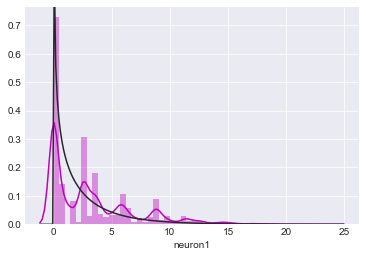

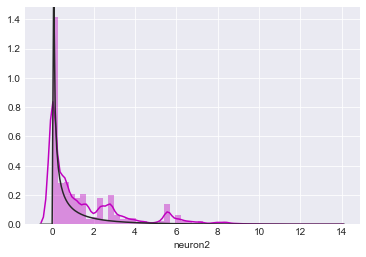

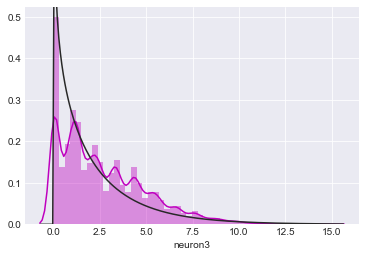

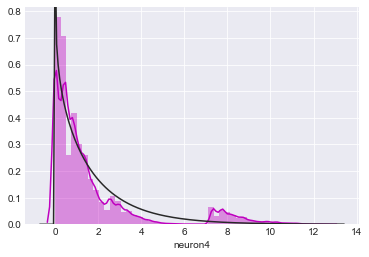

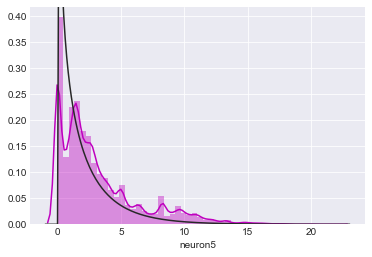

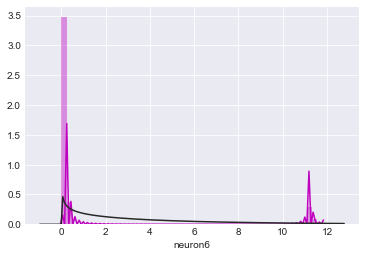

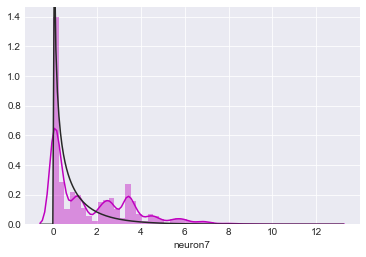

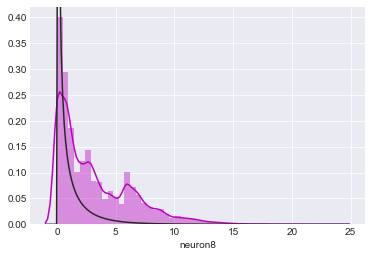

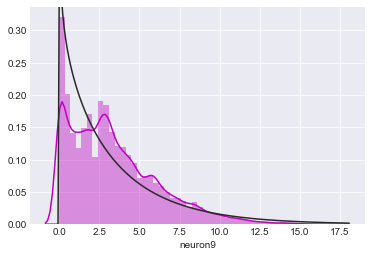

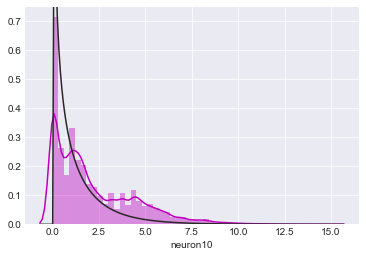

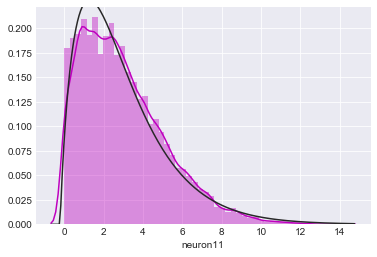

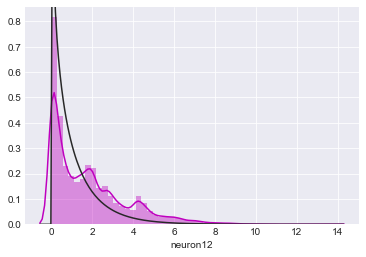

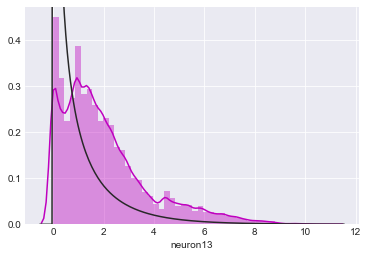

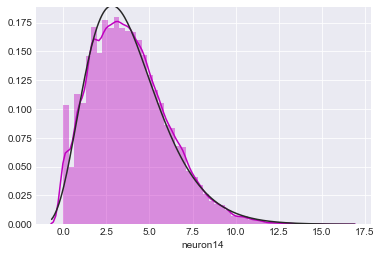

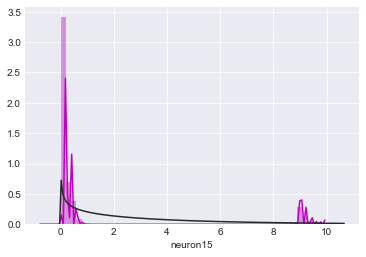

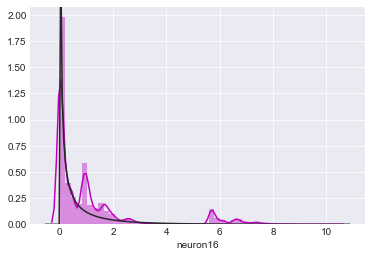

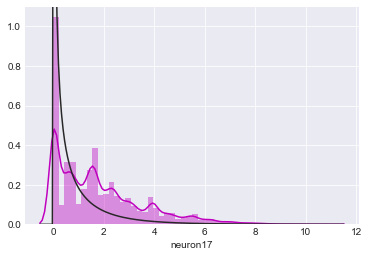

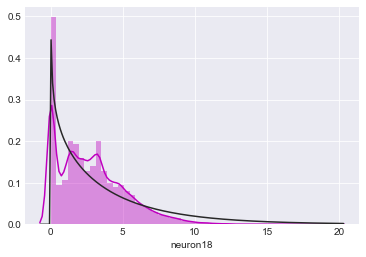

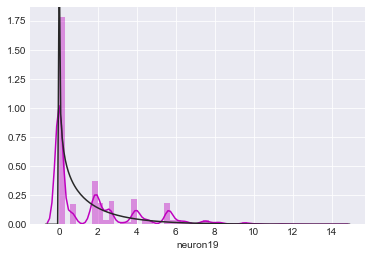

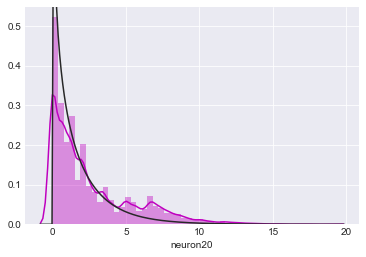

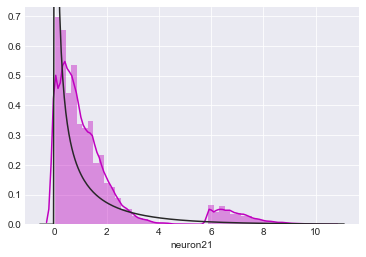

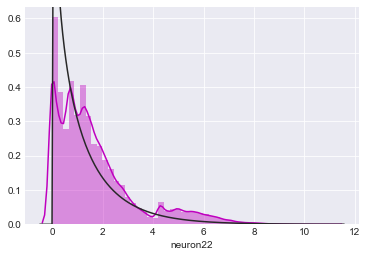

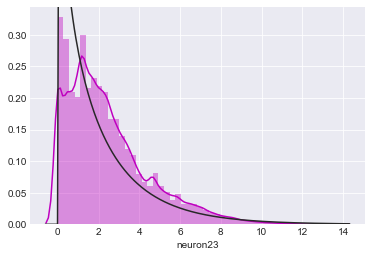

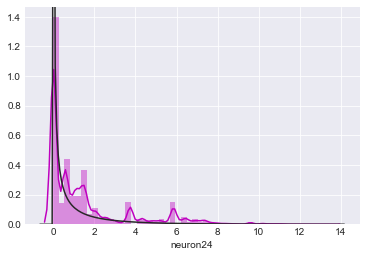

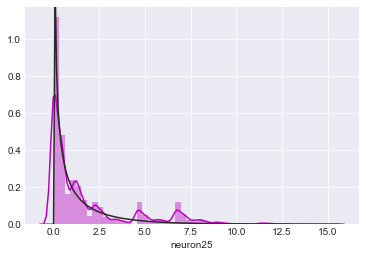

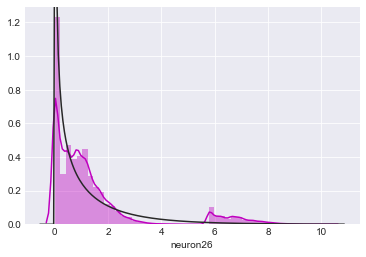

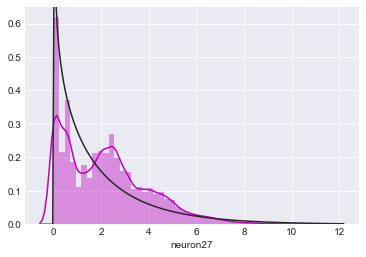

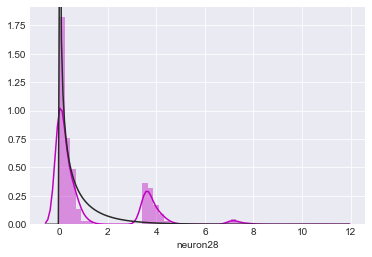

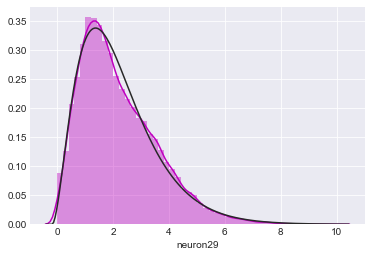

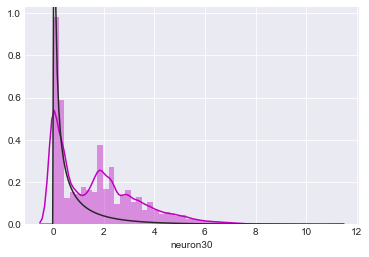

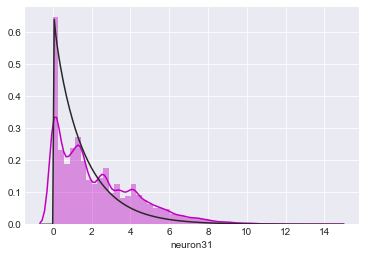

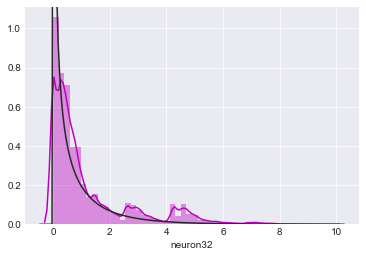

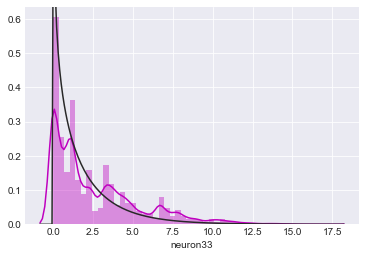

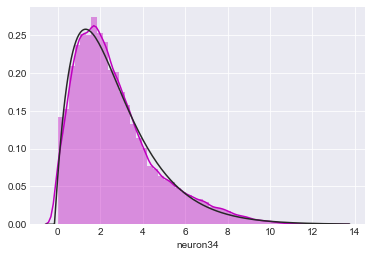

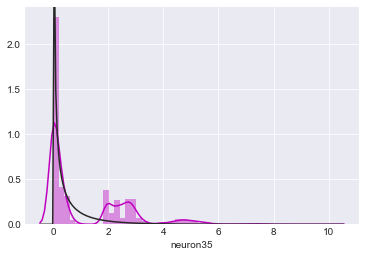

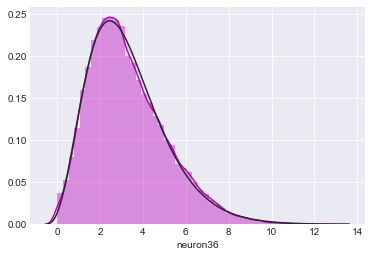

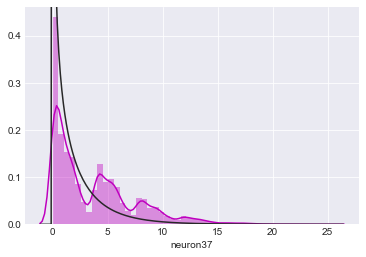

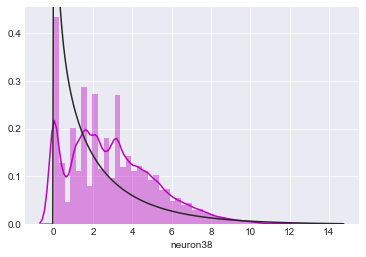

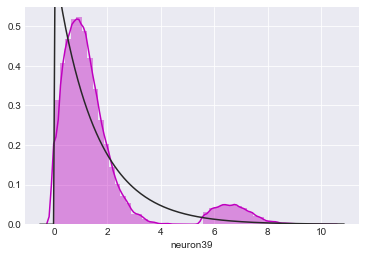

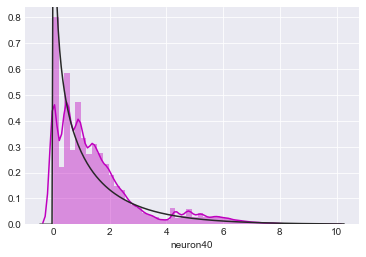

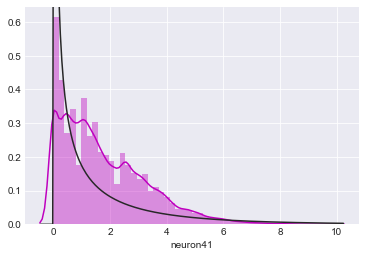

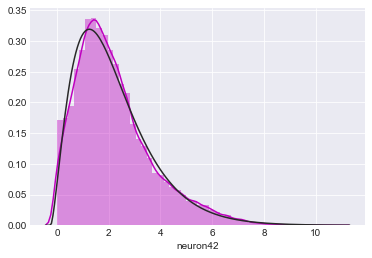

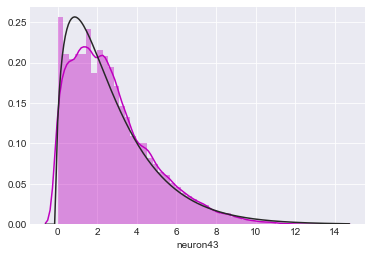

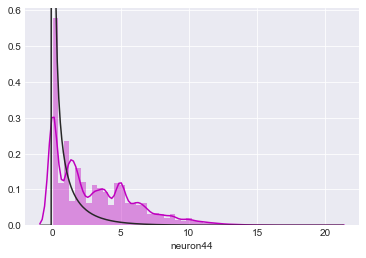

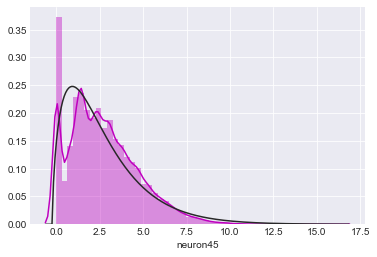

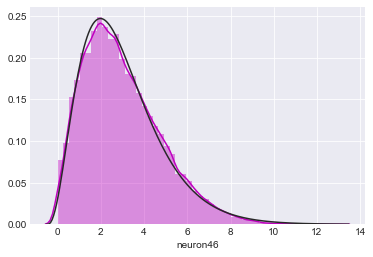

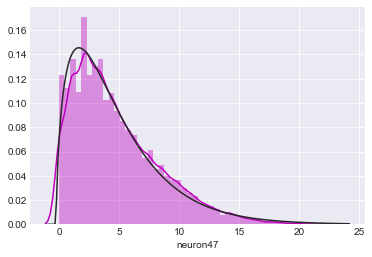

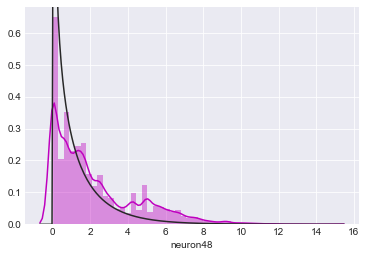

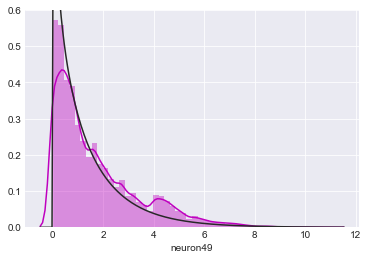

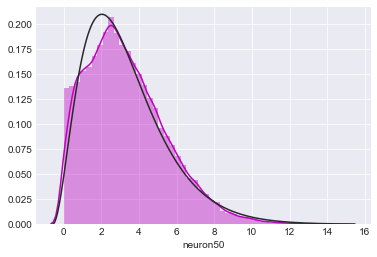

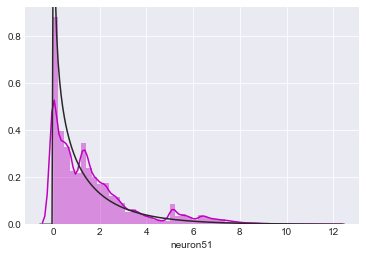

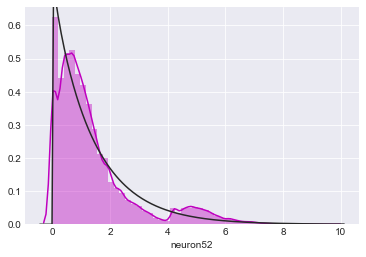

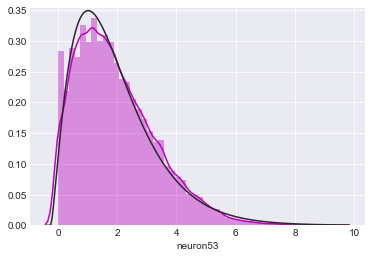

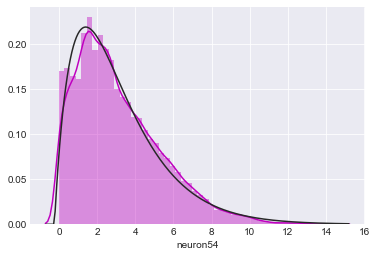

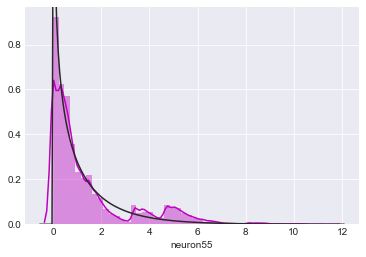

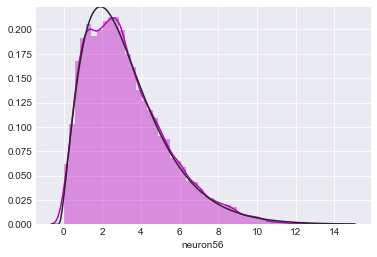

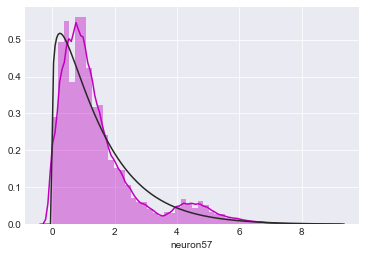

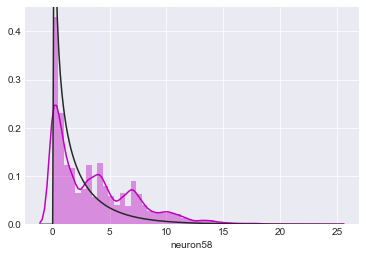

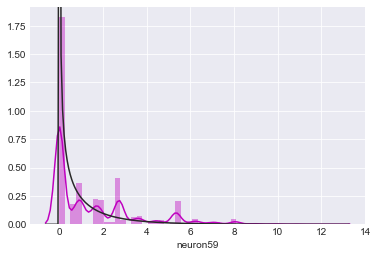

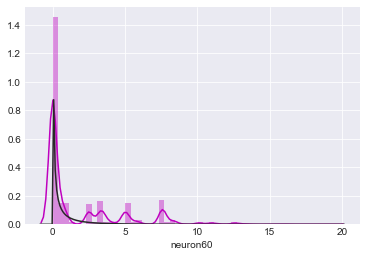

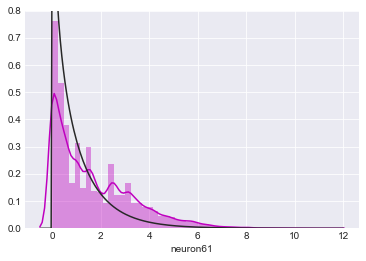

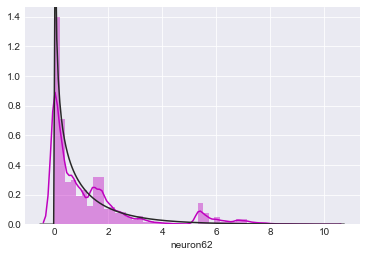

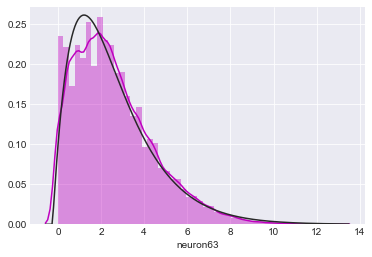

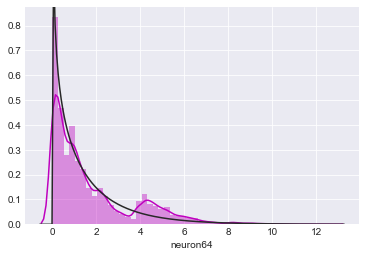

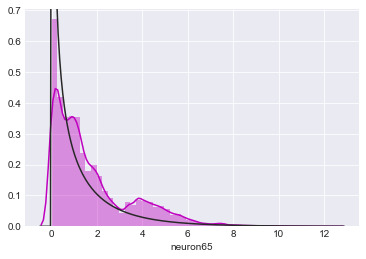

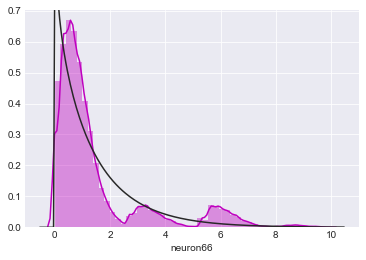

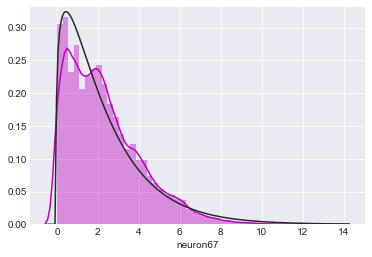

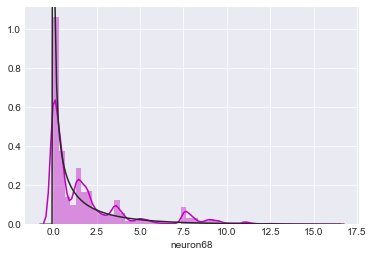

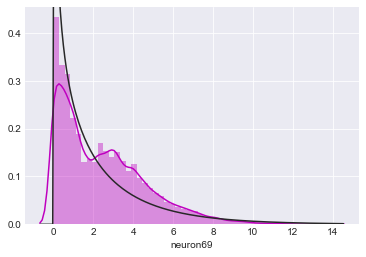

In [20]:
import scipy
import matplotlib.pyplot as plt

for neuron in bootstrapped_copy:
    plt.figure()
    sns.distplot(bootstrapped_copy[neuron], color='m', fit=stats.gamma)

In [22]:
a = (bootstrapped_copy["neuron46"].mean()**2) / bootstrapped_copy["neuron46"].var()
scale = (bootstrapped_copy["neuron46"].var() / bootstrapped_copy["neuron46"].mean())
a
scale
scipy.stats.kstest(bootstrapped_copy["neuron46"].values, 'gamma', args=(a, 0, scale))

2.709236458755516

1.0973132407053174

KstestResult(statistic=0.028972743724536766, pvalue=2.4544020896709602e-73)

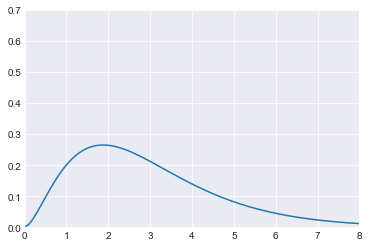

In [23]:
x = np.linspace (0, 20, 200) 
y1 = stats.gamma.pdf(x, a=a, scale=scale)

plt.plot(x, y1);
plt.ylim([0, 0.7]);
plt.xlim([0, 8]);
plt.show();

## TODO: for `is_neuron_selective()`, make sure implementation is sound, write-up documentation, and move to analysis_utils.py

In [ ]:
def is_neuron_selective(resampled_df, real_d_df, neuron, behavior_name, high_tail, low_tail):
    """Classifies a given neuron as selective or non-selective
    
    Classifies a given neuron as selective for a certain behavior, selective for 
    when that behavior is not performed, or non-selective. This is a custom function
    for carrying out a two-tailed hypothesis test.
    One can use this as a stand alone function to classify a single neuron for 
    a certain animal as either a <behavior> neuron, a "Non"-<behavior> neuron, or
    a "Non-selective" neuron.
    
    Args: 
        resampled_df: a resampled pandas DataFrame
        real_diff_df: a pandas DataFrame with one row that has the real difference of means
        values for a given animal and a corresponding behavior
        neuron: a single neuron of the neuron to classify use the 2-tailed hypothesis test
        behavior_name: the behavior to classify the neuron by, e.g. "Running" or "Non-Running"
        high_tail: the cutoff for the upper-tail of the distribution
        low_tail: the cutoff for the lower-tail of the distribution
    
    Returns:
        behavior_name, "Non-" + behavior_name, or "Non-selective" based on the result of the
        two-tailed hypothesis test 
    """
    if real_d_df[neuron]['d'] >= np.percentile(resampled_df[neuron], high_tail):
        return behavior_name
    elif real_d_df[neuron]['d'] <= np.percentile(resampled_df[neuron], low_tail):
        return "Non-" + behavior_name
    else: 
        return "Non-selective"

In [ ]:
is_neuron_selective(bootstrapped, real_diff_df, "neuron50", "OpenArms", 87.5, 5)

In [ ]:
def classify_neurons_for_beh(resampled_df, real_diff_df, behavior_name, high_tail, low_tail):
    """Classifies a given set of neurons
    
    This function simply calls is_neuron_selective for all the neurons 
    for a given animal. 
    
    Args: 
        resampled_df: a resampled pandas DataFrame
        real_diff_df: a pandas DataFrame with one row that has the real difference of means
        behavior_name: the behavior to classify each neuron by, e.g. "Running" or "Non-Running"
        high_tail: the cutoff for the upper-tail of the distribution
        low_tail: the cutoff for the lower-tail of the distribution
    
    Returns: 
        neurons_dict: a dictionary of all the neurons of a given animal as the keys,
        with each key having a corresponding classifcation as its value
    """
    neurons_dict = {}
    for neuron in resampled_df.columns:
        neurons_dict[neuron] = is_neuron_selective(resampled_df, real_diff_df, neuron, behavior_name, high_tail, low_tail)

    return neurons_dict

In [ ]:
classify_neurons_for_beh(bootstrapped, real_diff_df, "OpenArms_centerpoint", 87.5, 5)

In [ ]:
def activity_by_neurons(concated_df, neuron_names, *behaviors, frame_rate=10):
    """Computes the neuron activity rates for given behaviors
    
    This function computes the rates for a given animal's activity and  
    neuron, given some set of behaviors.

    Args: 
        concated_df: a concatenated pandas DataFrame of the neuron activity and 
        the corresponding behavior, for a given animal.
        neuron_names: the names of the neurons whose rates are to be computed.
        behaviors: a list of the behaviors for which to compute the activity rates. 
        frame_rate: the framerate to multiply the rate by, default is 10.

    Returns: 
        activity_df: a pandas DataFrame of the neuron activity rates.
    """
    activity_df = pd.DataFrame(columns=behaviors)
    for behavior in behaviors:
        if behavior in concated_df.columns:
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[concated_df[behavior] != 0, neuron_names].mean()
        elif '&' in behavior:
            beh1 = behavior.split('&')[0]
            beh2 = behavior.split('&')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) & ((concated_df[beh2] != 0)), neuron_names].mean()
        elif '|' in behavior:
            beh1 = behavior.split('|')[0]
            beh2 = behavior.split('|')[1]
            activity_df.loc[:, behavior] = frame_rate * concated_df.loc[(concated_df[beh1] != 0) | ((concated_df[beh2] != 0)), neuron_names].mean()

    return activity_df

In [ ]:
activity_rates_df = activity_by_neurons(neuron_concated_behavior, cell_transients_dataframe.columns, "ClosedArms_centerpoint", "OpenArms_centerpoint", "OpenArms_centerpoint&Running_frames", "ClosedArms_centerpoint&Running_frames", "Running_frames")

In [ ]:
activity_rates_df

In [ ]:
def all_activity_rates(*animals):
    pass

In [ ]:
def behavior_by_time(concated_df, behavior):
    """Split dataframe by time and behavior
    
    Args: 
        concated_df: a concatenated pandas DataFrame of the neuron activity and 
        the corresponding behavior, for a given animal.
        behavior: the specific behavior for which to generate the time intervaled dataframes 
    
    Returns: 
        time_bins: a dictionary of each intervaled dataframe
    """
    
    # Create copy of the dataframe for a certain behavior
    time_binned_df = concated_df.loc[concated_df[behavior] != 0].copy()
    time_binned_df.reset_index(drop=True, inplace=True)
    
    # Add a column of the trial time in the form of time deltas
    x = pd.to_timedelta('0.1s')
    time_binned_df.loc[:, "TIME"] = pd.Series(x*i for i in (time_binned_df.index))
    
    # Group the dataframe by 1 minute intervals
    grouped = time_binned_df.set_index("TIME").groupby(pd.Grouper(freq="1Min"))
    
    # Place each dataframe that contains the data for every 1 minute intervals into a dictionary
    time_bins = {}
    minute = 0
    for name, group in grouped:
        time_bins[minute] = grouped.get_group(name)
        minute += 1
        
    return time_bins

In [ ]:
time_binned_dfs = behavior_by_time(neuron_concated_behavior, "OpenArms_centerpoint")
time_binned_dfs[1]

In [ ]:
def plot_activity_rates(activity_rates_df):
    """Wrapper function for Plotly Bar Charts
        
        This function wraps the Plotly library Bar Chart plotting functionality
        in order to quickly and easily create a bar plot for 
    
    Args:
        activity_rates_df: the pandas DataFrame with all the neuron activity means,
        for corresponding behaviors
    """
    x = [beh.replace('_', "<br>") for beh in activity_rates_df.columns]
    y = [activity_rates_df[behavior].mean() for behavior in activity_rates_df.columns]

    trace1 = go.Bar(
        x=x,
        y=y,
        text=y,
        marker=dict(
            color='rgb(255,100,0)',
            line=dict(
                color='rgb(255,0,25)',
                width=2.5),
            ),
        opacity=0.7
    )

    data = [trace1]
    layout = go.Layout(
        title='Neuron Activity Rates by Behavior',
    )
    fig = go.Figure(data=data, layout=layout)
    plotly.offline.iplot(fig)

In [ ]:
import plotly
import plotly.graph_objs as go

plot_activity_rates(activity_rates_df)